In [1]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 

import qiskit
import numpy as np
import matplotlib.pyplot as plt
from hhl_algorithm import HHLAlgorithm as hhl
from hhl_algorithm_1bit import HHLAlgorithm as hhl_1

In [2]:
dz = 20 #mm

n_particles=[2]#0, 20, 20, 20]
events = len(n_particles)
layers = 3

n = np.sum(n_particles)

module_id = [l for l in range(1, layers+1)]
lx = [33 for x in range(1, layers+1)]
ly = [33 for x in range(1, layers+1)]
zs = [dz*l for l in range(1, layers+1)]

Detector = state_event_model.PlaneGeometry(module_id=module_id,lx = lx,ly = ly,z = zs)
# Detector = state_event_model.RectangularVoidGeometry(module_id=module_id,lx = lx,ly = ly,z=zs, void_x_boundary=5, void_y_boundary=5)

state_event_gen = StateEventGenerator(Detector, events = len(n_particles), n_particles=n_particles)#,
                                       #measurement_error=0.00, collision_noise=0.000)
state_event_gen.generate_random_primary_vertices({'x': 0, 'y': 0, 'z': 0})

[(0, 0, 0.0)]

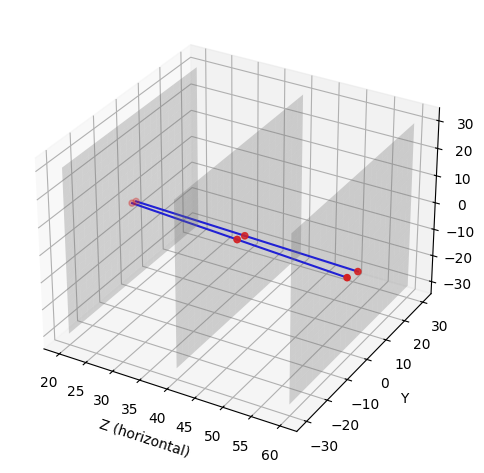

In [3]:
event_particles = []
for event in range(events):
    particles_list = []
    for particle in range(n):
        particle_dict = {
            'type' : 'MIP',
            'mass': 0.511,
            'q': 1
        }
        particles_list.append(particle_dict)
    event_particles.append(particles_list)

state_event_gen.generate_particles(event_particles)

event_tracks = state_event_gen.generate_complete_events()

event_tracks.plot_segments()

In [4]:
false_tracks = state_event_gen.make_noisy_event(drop_rate=0.0, ghost_rate=0.0)

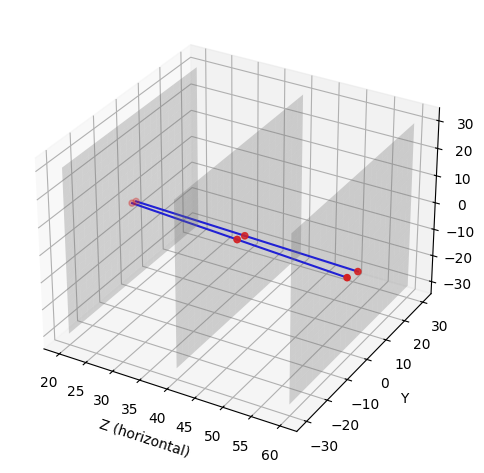

In [5]:
false_tracks.plot_segments()

In [6]:
print(len(false_tracks.modules[0].hits))
print(len(event_tracks.modules[0].hits))

2
2


In [7]:
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian

ham = SimpleHamiltonian(epsilon=1e-7, gamma=2.0, delta=1.0)

ham.construct_hamiltonian(event=event_tracks, convolution=True)
classical_solution = ham.solve_classicaly()
T = .45
discretized_classical_solution = (classical_solution > T).astype(int)
 

In [8]:
A = ham.A.todense()

In [9]:
matrix_A = A
vector_b = np.ones(len(A))

print("\nSolving Ax = b with:")
print("A =")
print(matrix_A)
print("b =")
print(vector_b)


Solving Ax = b with:
A =
[[ 3.          0.          0.          0.         -0.9114068   0.
   0.          0.        ]
 [ 0.          3.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          3.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          3.          0.          0.
   0.         -0.83202774]
 [-0.9114068   0.          0.          0.          3.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          3.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   3.          0.        ]
 [ 0.          0.          0.         -0.83202774  0.          0.
   0.          3.        ]]
b =
[1. 1. 1. 1. 1. 1. 1. 1.]


In [10]:
from scipy.linalg import solve

# Solve for x
x = solve(A, vector_b)

print("Solution x:", x)

Solution x: [0.47879118 0.33333333 0.33333333 0.46126051 0.47879118 0.33333333
 0.33333333 0.46126051]


In [11]:
print("HHL Algorithm Implementation")
print("=" * 60)

matrix_A = A
vector_b = np.ones(len(A))

print("\nSolving Ax = b with:")
print("A =")
print(matrix_A)
print("b =")
print(vector_b)

# Create an instance of the HHL algorithm.
hhl_solver = hhl(matrix_A, vector_b, num_time_qubits=5, shots=4096)
circuit = hhl_solver.build_circuit()
print("\nHHL Circuit:")
print(circuit.draw(output="text"))

# Run the circuit.
counts = hhl_solver.run()
print("\nRaw Measurement Counts:")
print(counts)

# # Plot the histogram of all measurement results.
# hhl_solver.plot_results("hhl_results.png")

# Extract the HHL solution (trimmed to the original dimension).
x_hhl = hhl_solver.get_solution()
print("\nExtracted HHL solution (normalized):")
print(x_hhl)

# Compute the theoretical solution for comparison (using the original system, not the padded one).
x_exact = np.linalg.solve(matrix_A, vector_b)
x_exact_normalized = x_exact / np.linalg.norm(x_exact)
print("\nTheoretical solution (normalized):")
print(x_exact_normalized)

HHL Algorithm Implementation

Solving Ax = b with:
A =
[[ 3.          0.          0.          0.         -0.9114068   0.
   0.          0.        ]
 [ 0.          3.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          3.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          3.          0.          0.
   0.         -0.83202774]
 [-0.9114068   0.          0.          0.          3.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          3.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   3.          0.        ]
 [ 0.          0.          0.         -0.83202774  0.          0.
   0.          3.        ]]
b =
[1. 1. 1. 1. 1. 1. 1. 1.]

HHL Circuit:
         »
 time_0: »
         »
 time_1: »
         »
 time_2: »
         »
 time_3: »
         »
 time_4: »
         »
    b_0: »
         »
    b_1: »
  

In [12]:
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks

truth_event = false_tracks
rec_tracks = get_tracks(ham, discretized_classical_solution, false_tracks)

In [ ]:
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
validator = evl(truth_event, rec_tracks)
validator.print_metrics()
validator.compute_metrics

                  EVENT VALIDATION METRICS                  
Total Reconstructed Tracks:                              2
Total Truth Tracks:                                      2
Reconstruction Efficiency:                         100.00%
Ghost Rate:                                          0.00%
Clone Fraction:                           0.00% (0 clones)
Hit Efficiency:                                    100.00%
Purity:                                            100.00%


In [ ]:
circuit.draw()

»
 time_0: »
         »
 time_1: »
         »
 time_2: »
         »
 time_3: »
         »
 time_4: »
         »
    b_0: »
         »
    b_1: »
         »
    b_2: »
         »
ancilla: »
         »
    c: 4/»
         »
«                                              ┌───┐                                      »
« time_0: ─────────────────────────────────────┤ H ├──────────────────────────────────────»
«                                              ├───┤                                      »
« time_1: ─────────────────────────────────────┤ H ├──────────────────────────────────────»
«                                              ├───┤                                      »
« time_2: ─────────────────────────────────────┤ H ├──────────────────────────────────────»
«                                              ├───┤                                      »
« time_3: ─────────────────────────────────────┤ H ├──────────────────────────────────────»
«                                              ├───┤                                      »
« time_4: ─────────────────────────────────────┤ H ├──────────────────────────────────────»
«         ┌────────────────────────────────────┴───┴─────────────────────────────────────┐»
«    b_0: ┤0                                                                             ├»
«         │                                                                              │»
«    b_1: ┤1 Initialize(0.35355,0.35355,0.35355,0.35355,0.35355,0.35355,0.35355,0.35355) ├»
«         │                                                                              │»
«    b_2: ┤2                                                                             ├»
«         └──────────────────────────────────────────────────────────────────────────────┘»
«ancilla: ────────────────────────────────────────────────────────────────────────────────»
«                                                                                         »
«    c: 4/════════════════════════════════════════════════════════════════════════════════»
«                                                                                         »
«                                                                     ┌───────┐»
« time_0: ─────────────────────────────────────────────────────■──────┤0      ├»
«                                                              │      │       │»
« time_1: ─────────────────────────────────────────■───────────┼──────┤1      ├»
«                                                  │           │      │       │»
« time_2: ─────────────────────────────■───────────┼───────────┼──────┤2 IQFT ├»
«                                      │           │           │      │       │»
« time_3: ─────────────────■───────────┼───────────┼───────────┼──────┤3      ├»
«                          │           │           │           │      │       │»
« time_4: ─────■───────────┼───────────┼───────────┼───────────┼──────┤4      ├»
«         ┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐└───────┘»
«    b_0: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├─────────»
«         │          ││          ││          ││          ││          │         »
«    b_1: ┤1 Unitary ├┤1 Unitary ├┤1 Unitary ├┤1 Unitary ├┤1 Unitary ├─────────»
«         │          ││          ││          ││          ││          │         »
«    b_2: ┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├─────────»
«         └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘         »
«ancilla: ─────────────────────────────────────────────────────────────────────»
«                                                                              »
«    c: 4/═════════════════════════════════════════════════════════════════════»
«                                                                              »
«         ┌───┐         ┌───┐┌───┐         ┌───┐┌───┐         ┌───┐┌───┐»
« time_0: ┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X ├────■────┤ X ├┤ X 

: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
from qiskit import QuantumCircuit, transpile

# Transpile to low-level gates for visualization
qc_low = transpile(circuit, basis_gates=['rx', 'ry', 'rz', 'cx'], optimization_level=0)


: 

: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
from qiskit import QuantumCircuit, qpy
from qiskit.qasm2 import dumps # This is the replacement for .qasm()

qc_quantum_only =  transpile(hhl_solver.get_quantum_only_circuit(), basis_gates=['rx', 'ry', 'rz', 'cx'], optimization_level=0)

# Save circuit as QPY (Qiskit's native format)
with open("my_circuit.qpy", "wb") as f:
    qpy.dump(qc_quantum_only, f)

# Later: Load it back
with open("my_circuit.qpy", "rb") as f:
    new_circuit = qpy.load(f)[0]


: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
from qiskit import qpy
from qiskit.qasm2 import dumps  # For QASM 2.0
import sys

# Load circuit(s) from QPY file
with open("my_circuit.qpy", "rb") as f:
    circuits = qpy.load(f)

# Get the first circuit (QPY can contain multiple)
circuit = circuits[0]

# OPTIONAL: Strip classical components if needed
from qiskit import QuantumCircuit
def strip_classical(circuit):
    qc_clean = QuantumCircuit(*circuit.qregs)
    for instr, qargs, cargs in circuit.data:
        if instr.name != "measure":
            qc_clean.append(instr, qargs, cargs)
    return qc_clean

# Comment this line out if you want to keep classical ops
circuit = strip_classical(circuit)

# Convert to QASM
try:
    qasm_str = dumps(circuit)
except Exception as e:
    print(f"Failed to export to QASM: {e}", file=sys.stderr)
    raise

# Save to file
with open("my_circuit.qasm", "w") as f:
    f.write(qasm_str)


C:\Users\GeorgeWilliam\AppData\Local\Temp\ipykernel_29004\727647710.py:16: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instr, qargs, cargs in circuit.data:


: 

: 

: 

: 

: 

: 

: 

: 

In [ ]:
import re
import math

def parse_angle(angle_str):
    """Convert angles like pi/2 to float."""
    try:
        return float(eval(angle_str, {"pi": math.pi}))
    except Exception:
        return None

def qasm_to_cqasm(qasm_path, cqasm_path):
    instr_map = {
        "rx": "rx",
        "ry": "ry",
        "rz": "rz",
        "cx": "cnot"
    }

    with open(qasm_path, "r") as f:
        lines = f.readlines()

    cqasm_lines = ["version 1.0"]
    qubit_count = 0

    for line in lines:
        line = line.strip()

        if line.startswith("qreg"):
            match = re.search(r"qreg\s+q\[(\d+)\];", line)
            if match:
                qubit_count = int(match.group(1))
                cqasm_lines.append(f"qubits {qubit_count}")

        elif line.startswith("rx") or line.startswith("ry") or line.startswith("rz"):
            match = re.match(r"(\w+)\(([^)]+)\)\s+q\[(\d+)\];", line)
            if match:
                gate, angle_str, qubit = match.groups()
                angle_val = parse_angle(angle_str)
                if angle_val is not None:
                    cqasm_lines.append(f"{gate} q[{qubit}], {angle_val}")
                else:
                    print(f"Warning: could not parse angle '{angle_str}' in line: {line}")

        elif line.startswith("cx"):
            match = re.match(r"cx\s+q\[(\d+)\],\s*q\[(\d+)\];", line)
            if match:
                control, target = match.groups()
                cqasm_lines.append(f"cnot q[{control}], q[{target}]")

    with open(cqasm_path, "w") as f:
        f.write("\n".join(cqasm_lines))

    print(f"✅ Converted QASM → cQASM: {cqasm_path}")


: 

: 

: 

: 

: 

: 

: 

: 

# Classical testing HHL

In [14]:
%load_ext autoreload
%autoreload 2
from LHCB_Velo_Toy_Models.state_event_generator import *
from LHCB_Velo_Toy_Models import state_event_model 
from LHCB_Velo_Toy_Models.simple_hamiltonian import SimpleHamiltonian
import qiskit
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve
from hhl_algorithm import HHLAlgorithm as hhl
from hhl_algorithm_1bit import HHLAlgorithm as hhl_1
from LHCB_Velo_Toy_Models.simple_hamiltonian import get_tracks
from LHCB_Velo_Toy_Models.toy_validator import EventValidator as evl
import itertools as it

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# --- Constants ---
dz = 20  # mm layer spacing
layers = 5
n_particles = [20, 20, 20, 20, 20]
events = len(n_particles)
n = np.sum(n_particles)

# Detector configuration
module_id = list(range(1, layers + 1))
lx = [33] * layers
ly = [33] * layers
zs = [dz * l for l in range(1, layers + 1)]

# Noise and error parameters
measurement_errors = collision_noises = ghost_rates = drop_rates = np.round(np.linspace(0.00, 0.10, 11), 2)

# Results container
results = []

# --- Main parameter sweep ---
print("Starting parameter sweep...")

for mes_error, coll_noise, ghost, drop in it.product(measurement_errors, collision_noises, ghost_rates, drop_rates):
    print(f"\nRunning simulation with:")
    print(f"  Measurement error = {mes_error}")
    print(f"  Collision noise   = {coll_noise}")
    print(f"  Ghost rate        = {ghost}")
    print(f"  Drop rate         = {drop}")

    # --- Detector setup ---
    Detector = state_event_model.PlaneGeometry(
        module_id=module_id, lx=lx, ly=ly, z=zs
    )

    # --- State event generator setup ---
    state_event_gen = StateEventGenerator(
        Detector,
        events=events,
        n_particles=n_particles,
        measurement_error=mes_error,
        collision_noise=coll_noise
    )

    state_event_gen.generate_random_primary_vertices({'x': 1, 'y': 1, 'z': 1})

    event_particles = [[{'type': 'MIP', 'mass': 0.511, 'q': 1} for _ in range(n)] for _ in range(events)]

    state_event_gen.generate_particles(event_particles)
    event_tracks = state_event_gen.generate_complete_events()

    # --- Inject noise into events ---
    false_tracks = state_event_gen.make_noisy_event(drop_rate=drop, ghost_rate=ghost)

    # --- Hamiltonian setup and solve ---
    ham = SimpleHamiltonian(epsilon=1e-7, gamma=2.0, delta=1.0)
    ham.construct_hamiltonian(event=event_tracks, convolution=True)

    print("Solving classical Hamiltonian...")
    classical_solution = ham.solve_classicaly()
    discretized_solution = (classical_solution > 0.45).astype(int)

    # --- Track reconstruction and validation ---
    rec_tracks = get_tracks(ham, discretized_solution, false_tracks)
    validator = evl(false_tracks, rec_tracks)
    metrics = validator.compute_metrics()

    print(f"  -> Metrics: {metrics}")

    # --- Store result ---
    results.append({
        'measurement_error': mes_error,
        'collision_noise': coll_noise,
        'ghost_rate': ghost,
        'drop_rate': drop,
        'metrics': metrics
    })

print("\nParameter sweep completed. Saving results...")

# --- Save results to JSON file ---
with open("results.json", "w") as f:
    json.dump(results, f, indent=4)

print("Results saved to 'results.json'.")

Starting parameter sweep...

Running simulation with:
  Measurement error = 0.0
  Collision noise   = 0.0
  Ghost rate        = 0.0
  Drop rate         = 0.0
Solving classical Hamiltonian...
  -> Metrics: {'ghost_rate': 0.0, 'clone_fraction': 0.0, 'reconstruction_efficiency': 0.0, 'hit_efficiency': 0.0, 'purity': 0.0, 'total_rec_tracks': 0, 'total_truth_tracks': 100, 'ghost_tracks': [], 'clones_count': 0}

Running simulation with:
  Measurement error = 0.0
  Collision noise   = 0.0
  Ghost rate        = 0.0
  Drop rate         = 0.01


: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 

: 